In [1]:
import os
import sys
libdir = os.path.dirname('/usr/people/muntjewe/git/laura_scripts/')
sys.path.insert(0, libdir) 


from libpyvarex import libplot
from libpyvarex import libtimeseries

In [2]:
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
# Name some Cartopy projections for ease of use\n",
myproj = ccrs.PlateCarree()

In [3]:
import cartopy.feature as cf

In [4]:
import pandas as pd
from scipy.stats import ttest_ind

In [5]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from matplotlib import cm

In [6]:
import numpy as np
import xarray as xr

In [7]:
## figure location
fig_directory='/usr/people/muntjewe/LENTIS/figs/datapaper/'


### Open the data from LENTIS and from ERA5 

In [9]:
ds_ERA=xr.open_dataset('/net/pc200021/nobackup_1/users/muntjewe/LENTIS/lproc/ERA/era5_t2m_ECE3grid_1991001-202012.nc',decode_times=False)
units, reference_date = ds_ERA.time.attrs['units'].split('since')
ds_ERA['time'] = pd.date_range(start=reference_date, periods=ds_ERA.sizes['time'], freq='MS')

tasERA=ds_ERA['t2m']

In [1]:

# # make 2D annual mean tas from LENTIS

tas_lentis_ANN = []


for i in np.arange(1,16+1):
    for j in np.arange(0,9+1):
        # open the dataset
        print('working on: '+str(i).zfill(2)+str(j))
        ds=xr.open_dataset('/usr/people/muntjewe/nobackup/nobackup_1/LENTIS/PD/Amon/tas/tas_h'+str(i).zfill(2)+str(j)+'.nc')
        annual_mean = ds['tas'].groupby('time.year').mean('time')
        tas_lentis_ANN.append(annual_mean)
        ds.close()


In [11]:
tas_lentis_ANN_xr = xr.DataArray(np.asarray(tas_lentis_ANN), 
coords={'ens': np.arange(1,160+1), 'year': np.arange(2000,2009+1),'lat': tasERA['lat'],'lon': tasERA['lon']}, 
dims=["ens", "year", "lat", "lon"])


In [12]:
new_arr = tas_lentis_ANN_xr.stack(years=['ens','year'])

### Do some basic statistics, mean

To calculate the absolute bias

In [13]:
mean_era = tasERA.mean(dim='time')
mean_lentis = new_arr.mean(dim='years')
anom = mean_lentis - mean_era

### Calculate the significance of the bias

Do standard t-test on the distributions per grid cell of 10-year ERA data and 1600 year LENTIS data

In [16]:
ann_mean_era = tasERA.groupby('time.year').mean(dim='time')

In [17]:
ann_mean_lentis = new_arr.transpose('years', 'lat', 'lon')

In [20]:
statres, pval = ttest_ind(ann_mean_era, ann_mean_lentis,axis=0)

In [21]:
nosig_area   = np.where(pval > 0.05)
lons, lats = np.meshgrid(anom.lon, anom.lat)

### Plot the bias figure with dots for significance

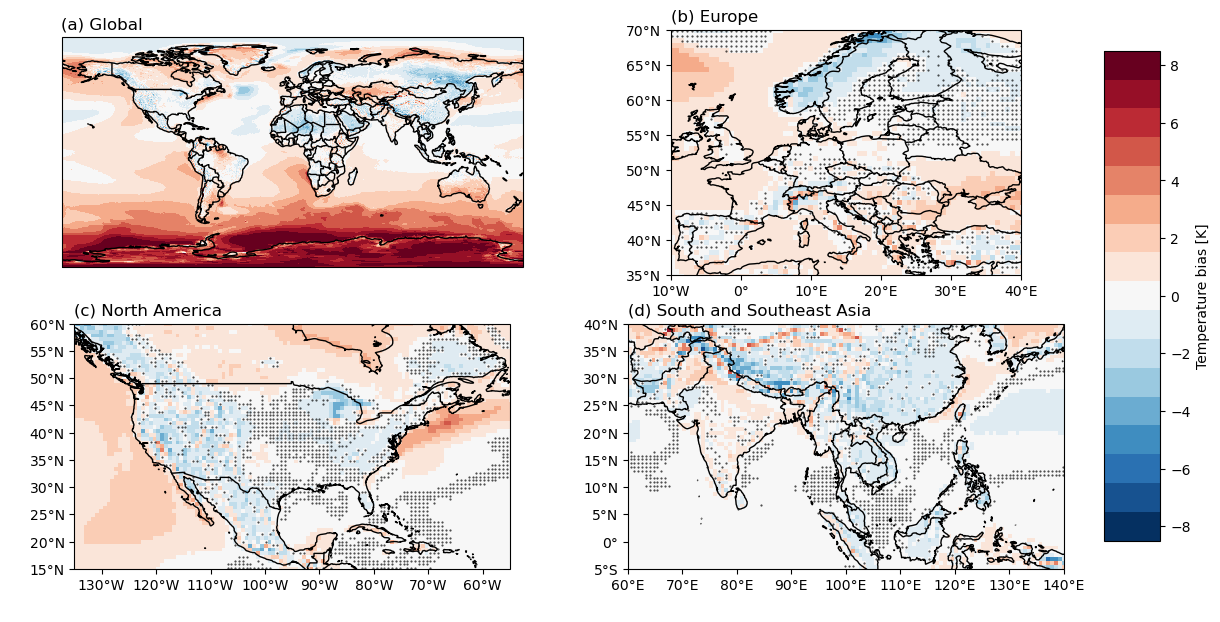

<Figure size 640x480 with 0 Axes>

In [23]:

fig = plt.figure(figsize=(14,7))
gs = gridspec.GridSpec(2, 2)
#cmap = cmo.balance
#cmap = cm.get_cmap('cmo.balance', 17) 
cmap = cm.get_cmap('RdBu_r', 17) 

vmin1=-8.5
vmax1=8.5


lon_formatter = LongitudeFormatter(zero_direction_label=False)
lat_formatter = LatitudeFormatter()



extent=[-180, -180, -90, 90]
ax1 = fig.add_subplot(gs[0,0], projection=myproj)
ax1.coastlines()
ax1.add_feature(cf.BORDERS)
ax1.set_ylabel('')
ax1.set_xlabel('')
im1 = anom.plot.imshow(ax=ax1, vmin=vmin1, vmax=vmax1, cmap=cmap, add_colorbar=False)
ax1.set_title('(a) Global',loc='left',fontsize=12)


extent=[-10, 40, 35, 70]
ax2 = fig.add_subplot(gs[0,1], projection=myproj)
ax2.set_extent(extent, crs=ccrs.PlateCarree())
ax2.coastlines()
ax2.add_feature(cf.BORDERS)
ax2.set_xticks(np.arange(-180, 181, 10), crs=myproj)
ax2.set_yticks(np.arange(-90, 91, 5), crs=myproj)
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
ax2.set_xlim(extent[0], extent[1])
ax2.set_ylim(extent[2], extent[3])
im1 = anom.plot.imshow(ax=ax2, vmin=vmin1, vmax=vmax1, cmap=cmap, add_colorbar=False)
_ = ax2.scatter(lons[nosig_area], lats[nosig_area], marker = '.', s = 1, c = 'k', alpha = 0.8, transform = myproj)
ax2.set_ylabel('')
ax2.set_xlabel('')
ax2.set_title('(b) Europe ',loc='left',fontsize=12)

extent=[-135, -55, 15, 60]
ax3 = fig.add_subplot(gs[1,0], projection=myproj)
ax3.set_extent(extent, crs=ccrs.PlateCarree())
ax3.coastlines()
ax3.add_feature(cf.BORDERS)
ax3.set_xticks(np.arange(-180, 181, 10), crs=myproj)
ax3.set_yticks(np.arange(-90, 91, 5), crs=myproj)
ax3.xaxis.set_major_formatter(lon_formatter)
ax3.yaxis.set_major_formatter(lat_formatter)
ax3.set_xlim(extent[0], extent[1])
ax3.set_ylim(extent[2], extent[3])
im1 = anom.plot.imshow(ax=ax3, vmin=vmin1, vmax=vmax1, cmap=cmap, add_colorbar=False)
_ = ax3.scatter(lons[nosig_area], lats[nosig_area], marker = '.', s = 1, c = 'k', alpha = 0.8, transform = myproj)
ax3.set_ylabel(' ')
ax3.set_xlabel(' ')
ax3.set_title('(c) North America ',loc='left',fontsize=12)

extent=[60, 140, -5, 40]
ax4 = fig.add_subplot(gs[1,1], projection=myproj)
ax4.set_extent(extent, crs=ccrs.PlateCarree())
ax4.coastlines()
ax4.add_feature(cf.BORDERS)
ax4.set_xticks(np.arange(-180, 181, 10), crs=myproj)
ax4.set_yticks(np.arange(-90, 91, 5), crs=myproj)
ax4.xaxis.set_major_formatter(lon_formatter)
ax4.yaxis.set_major_formatter(lat_formatter)
ax4.set_xlim(extent[0], extent[1])
ax4.set_ylim(extent[2], extent[3])
im1 = anom.plot.imshow(ax=ax4, vmin=vmin1, vmax=vmax1, cmap=cmap, add_colorbar=False)
_ = ax4.scatter(lons[nosig_area], lats[nosig_area], marker = '.', s = 1, c = 'k', alpha = 0.8, transform = myproj)
ax4.set_ylabel('')
ax4.set_xlabel('')
ax4.set_title('(d) South and Southeast Asia ',loc='left',fontsize=12)



# add space for colour bar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.15, 0.04, 0.7])
fig.colorbar(im1, cax=cbar_ax, label='Temperature bias [K]')



plt.show()
plt.tight_layout()